# Dataset available at kaggle

https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset

# Install libraries, packages and dataset

In [1]:
# !git clone https://github.com/parth1620/Facial-Expression-Dataset.git
#!pip install -U git+https://github.com/albumentations-team/albumentations
#!pip install timm
#!pip install --upgrade opencv-contrib-python

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Configurations

In [2]:
TRAIN_IMG_FOLDER_PATH = '/Users/trananhngan/Downloads/ML_model/Facial-Expression-Dataset/train/'
VALID_IMG_FOLDER_PATH = '/Users/trananhngan/Downloads/ML_model/Facial-Expression-Dataset/validation/'

LR = 0.001
BATCH_SIZE = 32 
EPOCHS = 100 
DEVICE = 'cpu'
MODEL_NAME = 'efficientnet_b0'

# Load Dataset

In [3]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [4]:
# Data augmentation
train_augs = T.Compose([
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomRotation(degrees=(-20, +20)),
    T.ToTensor() #PIL / numpy arr -> torch tensor -> (h,w,c) -> (c,h,w)
])
valid_augs = T.Compose([ # converting the image into a Tensor array, which can be changed to different dimensions.
    T.ToTensor()
])

In [5]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform=train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform=valid_augs)

In [6]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 57528
Total no. of examples in validset : 14244


In [7]:
print(trainset.class_to_idx)

{'angry': 0, 'confident': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprise': 7, 'unconfident': 8}


In [9]:
num_of_class = len(trainset.class_to_idx)
print(num_of_class)

9


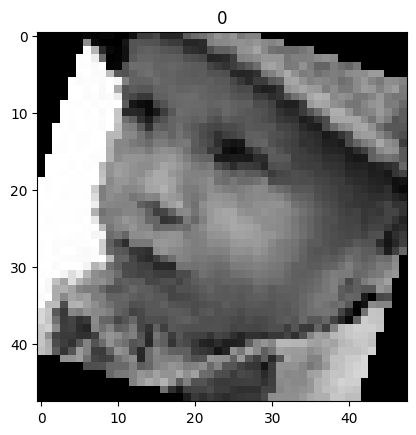

In [9]:
image, label = trainset[20]
plt.imshow(image.permute(1,2,0))
plt.title(label);

# Load Dataset into Batches

In [10]:
from torch.utils.data import DataLoader

In [11]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [12]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 1798
Total no. of batches in validloader : 446


In [13]:
for images, labels in trainloader:
  break;

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


# Create Model

In [14]:
!pip3 install timm


[notice] A new release of pip is available: 24.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [15]:
import timm
from torch import nn

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
class FaceModel(nn.Module):
  def __init__(self):
    super(FaceModel, self).__init__()
    self.eff_net = timm.create_model('efficientnet_b0', pretrained = True, num_classes = 9)

  def forward(self, images, labels = None):
    logits = self.eff_net(images)

    if labels != None:
      loss = nn.CrossEntropyLoss()(logits, labels)
      return logits, loss
    return logits


In [17]:
model = FaceModel()
model.to(DEVICE);

# Create Train and Eval Function

In [18]:
from tqdm import tqdm

In [19]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [20]:
def train_fn(model, dataloader, optimizer, current_epo):
  model.train()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc = "EPOCH" + "[TRAIN]" + str(current_epo + 1) + '/' + str(EPOCHS))

  for t,data in enumerate(tk):
    images, labels = data
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss': '%6f' %float(total_loss / (t+1)), 'acc': '%6f' %float(total_acc / (t+1)),})

  return total_loss / len(dataloader), total_acc / len(dataloader)

In [21]:
def eval_fn(model, dataloader, current_epo):
  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc = "EPOCH" + "[VALID]" + str(current_epo + 1) + '/' + str(EPOCHS))

  for t,data in enumerate(tk):
    images, labels = data
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    logits, loss = model(images, labels)

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss': '%6f' %float(total_loss / (t+1)), 'acc': '%6f' %float(total_acc / (t+1)),})

  return total_loss / len(dataloader), total_acc / len(dataloader)

# Create Training Loop

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [24]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss, train_acc = train_fn(model, trainloader, optimizer, i)
  valid_loss, valid_acc = eval_fn(model, validloader, i)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best-weights.pt')
    print('SAVE-BEST-WEIGHTS')
    best_valid_loss = valid_loss

EPOCH[TRAIN]1/100:   0%|          | 0/1798 [00:00<?, ?it/s]


IndexError: Target 8 is out of bounds.

# Inference

In [ ]:
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

def view_classify(img, ps):

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)

    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [ ]:
#torch.cuda.clear_cache()

AttributeError: module 'torch.cuda' has no attribute 'clear_cache'

In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms

label = 0

# Load and transform the image
image_path = 'img2.jpg'
image = Image.open(image_path)

# Define the transformation to convert the image to tensor and normalize it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image = transform(image)
image = image.unsqueeze(0)

logits = model(image.to(DEVICE))
probs = nn.Softmax(dim=1)(logits)

view_classify(image.squeeze(), probs)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/trananhngan/Downloads/ML_model/img2.jpg'

### Webcam Detection

In [ ]:
!pip3 install opencv-python




Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 54.8 MB 18.1 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
import cv2


In [ ]:
cap = cv2.VideoCapture(0)

model = FaceModel()
model.load_state_dict(torch.load('/Users/trananhngan/Downloads/ML_model/best-weights.pt', map_location=torch.device('cpu')))

device = torch.device('cpu')
model.to(device)

transform = T.Compose([
    T.ToPILImage(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

classes ={0: 'angry', 1:'disgust', 2:'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'suprise'}

while True:
    ret, frame = cap.read()
    if not ret:
        break

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    face = transform(rgb_frame)
    face = face.unsqueeze(0).to(device)


    with torch.no_grad():
        output = model(face.to(device))
        _, predicted = torch.max(output, 1)
        emotion = classes[int(predicted)]


    cv2.putText(frame, emotion, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Webcam', frame)


    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()